# Foundation of Data Analysis - WS24

## Lab Assignment - Supervised Learning (Template)

**Due date: 9:45am on 11.12.2024**

This jupyter notebook serves as a template for the supervised lab assignment for you to work in. Please consult the exam sheet (supervised_lab_ws24.pdf) that you can find on Moodle for all the tasks as well as rules and regulations pertaining the assignment. Most importantly, you are only allowed to use the libraries/functions imported in the first code cell (for some tasks you are limited to fewer libraries - please see the instructions). The comments atop each cell are reminders of the tasks but do not replace the instructions in the pdf (the latter is binding).

Do not hesitate to email me (Christoph Luther) at christoph.luther@univie.ac.at or post on the discussion forum on Moodle with any questions you may have.

Do not forget to set random seeds for reproducibility whenever necessary. Good luck!

In [292]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, zero_one_loss, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

## 1) Cross Validation for Random Forests

In [293]:
# 1.0 Load the data
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [294]:
# 1.1 Print first ten rows
train.head(10)

,X1,X2,Y
0,0.942786,2.513357,0
1,0.001826,-0.171908,1
2,-0.225599,-1.572651,1
3,0.551667,-0.279003,1
4,0.789346,2.178841,0
5,0.697576,-0.435335,0
6,0.787238,1.960758,0
7,1.226155,0.932646,0
8,-0.177914,0.668113,1
9,0.740864,0.516436,0


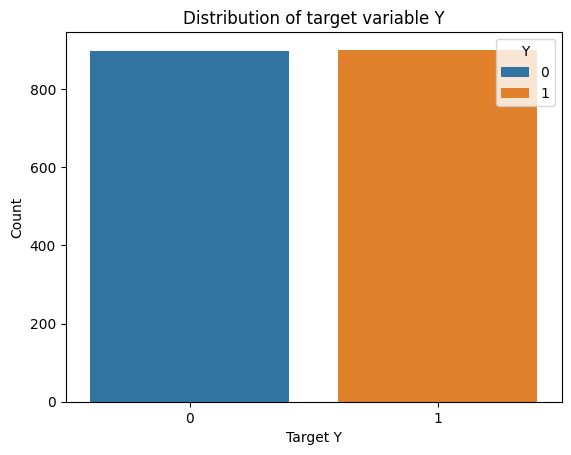

In [295]:
# 1.2 Target value evenly distributed?
sns.countplot(x = 'Y', hue = 'Y', data = train)
plt.title('Distribution of target variable Y')
plt.xlabel('Target Y')
plt.ylabel('Count')
plt.show()

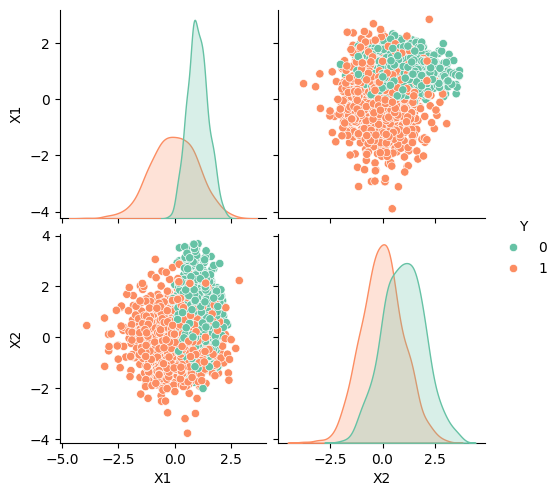

In [296]:
# 1.3 Pairplot
sns.pairplot(train, hue = 'Y', palette = 'Set2')
plt.show()

In [297]:
# 1.4 Perform random forest
# Seperating features & targets (class labels) for train datasets 
X_train = train[['X1', 'X2']]
y_train = train['Y']

# Seperating features & targets (class labels) for test datasets 
X_test = test[['X1', 'X2']]
y_test = test['Y']

# Initializing and training the Random Forest model 
rf_model = RandomForestClassifier(random_state = 0) 
rf_model.fit(X_train, y_train)

# Making predictions on train datasets and test datasets 
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Calculating accuracy for train data and test data 
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Printing the accuracies
print(f"Train Accuracy: {train_accuracy:.2f}") # Showing float-point numbers with 2 decimal numbers 
print('Test Accuracy: ', test_accuracy)

Train Accuracy: 1.00
Test Accuracy:  0.79


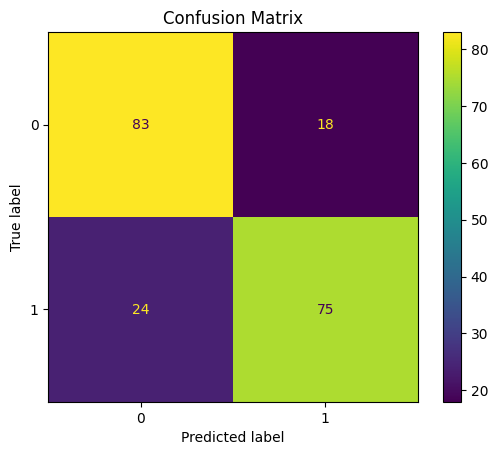

In [298]:
# 1.5 Confusion matrix
# Computing the confusion matrix
c_matrix = confusion_matrix(y_test, y_pred_test)

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,  display_labels=rf_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [299]:
# 1.6 0-1 loss from the confusion matrix
def calculate_model_risk(conf_matrix):
    # risk = Number of misclassified samples / total number of samples
    # misclassfiied samples = total number of samples - sum of diagonal elements
    misclassified_samples = conf_matrix.sum() - conf_matrix.trace()
    total_samples = conf_matrix.sum()
    risk = misclassified_samples / total_samples
    return risk

# model risk 
model_risk = calculate_model_risk(c_matrix)
print('Model risk (0 - 1 loss): ', model_risk)

Model risk (0 - 1 loss):  0.21


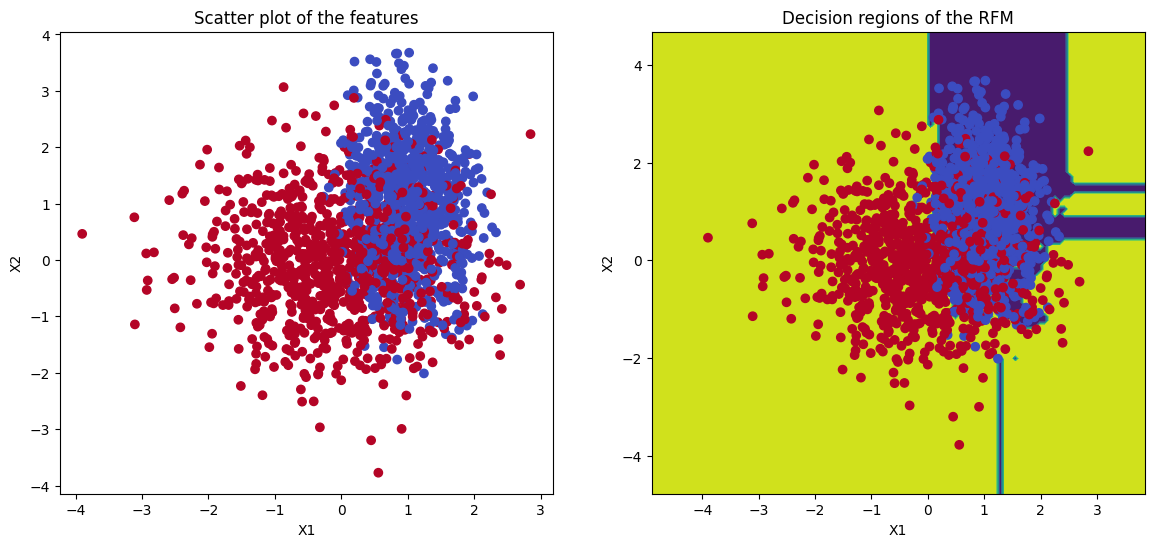

In [300]:
# 1.7 Scatter and decision regions

# Creating two horizontal subplots with a width of 14 and height of 6
fig, axes = plt.subplots(1, 2, figsize = (14, 6))

# Left subplot: scatter plot of the features
axes[0].scatter(X_train['X1'], X_train['X2'], c = y_train, cmap = 'coolwarm')
axes[0].set_title('Scatter plot of the features')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')

# Right subplot: Decision regions of the RFM
DecisionBoundaryDisplay.from_estimator(rf_model, X_train, response_method = 'predict', ax = axes[1])

# Overlay the training data points
axes[1].scatter(X_train['X1'], X_train['X2'], c = y_train, cmap = 'coolwarm') # cmap ensures distinct colors for the two classes
axes[1].set_title('Decision regions of the RFM')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')

# Printing the plot
plt.show()

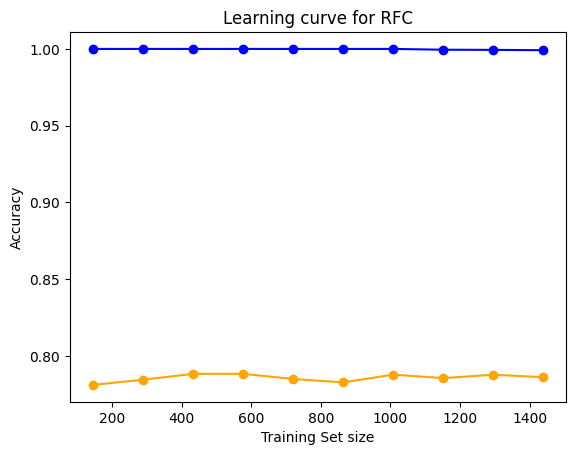

In [301]:
# 1.8 Learning Curve

# Defining the steps for the training set sizes 
train_sizes = np.linspace(0.1, 1.0, 10)

# Computing learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = RandomForestClassifier(random_state = 0), 
    X = X_train,
    y = y_train,
    train_sizes = train_sizes, 
)

# Calculating the mean accuracy for training and validation scores 
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

# Plotting the leaning curve
plt.plot(train_sizes, train_scores_mean, label = 'Training Accuracy', marker = 'o', color = 'blue')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation Accuracy', marker = 'o', color = 'orange')
plt.title('Learning curve for RFC')
plt.xlabel('Training Set size')
plt.ylabel('Accuracy')
plt.show()

# 1.9 Explain problem
Overfitting: This model shows a very high training accuracy, close to 100% on all training set sizes, which means it prefectly fits the classifier on the training data. However, there is a significant drop in validation accuracy with increased size in training, therefore poor generalization on unseen data. This pattern points out that this model overfits by fitting the noise and specifices of the training data rather than generalizable patterns.  

In [302]:
# 1.10 Cross validation
values = [1, 2, 3, 5, 10, 20] # max-depth values 

# 10-fold cross-validation 
def cross_validate_rf(X, y, max_depth, folds_n = 10):
    fold_size = len(X) // folds_n
    losses = [] # list to store 0-1 losses for each fold

    for fold in range(folds_n):
        # dividing the data into training & validation sets
        start_val = fold * fold_size
        end_val = (fold + 1) * fold_size if fold < folds_n - 1 else len(X)

        val_X, val_y = X[start_val:end_val], y[start_val:end_val]
        X_train = np.concatenate((X[:start_val], X[end_val:]), axis=0)
        y_train = np.concatenate((y[:start_val], y[end_val:]), axis=0)

        # Training the RFM
        rf = RandomForestClassifier(random_state=0, max_depth=max_depth)
        rf.fit(X_train, y_train)

        # Prediction on validation set
        y_pred_val = rf.predict(val_X)

        # Calculating the 0 - 1 loss
        loss = zero_one_loss(val_y, y_pred_val)
        losses.append(loss)

    # Returning the average loss in all folds
    return np.mean(losses)

# Performing the cross-validation for every max-depth & finding the best one 
X_train_np, y_train_np = X_train.to_numpy(), y_train.to_numpy()  # Converting to NumPy arrays
average_losses = []

for max_depth in values:
    avg_loss = cross_validate_rf(X_train_np, y_train_np, max_depth)
    average_losses.append(avg_loss)
    print(f'Max Depth: {max_depth}, Average loss:  {avg_loss:.3f}')

# Finding the best max_depth
best_max_depth = values[np.argmin(average_losses)]
print(f'Best max_depth: {best_max_depth} with minimum loss: {min(average_losses):.3f}' )

Max Depth: 1, Average loss:  0.212
Max Depth: 2, Average loss:  0.199
Max Depth: 3, Average loss:  0.197
Max Depth: 5, Average loss:  0.191
Max Depth: 10, Average loss:  0.202
Max Depth: 20, Average loss:  0.207
Best max_depth: 5 with minimum loss: 0.191


In [303]:
# 1.11 Train best
rf_best = RandomForestClassifier(max_depth = best_max_depth, random_state = 0)

# Training the model on entire train datasets
rf_best.fit(X_train, y_train)

# Evaluting the model on the test dataset
y_pred_test = rf_best.predict(X_test)

# calculating 0 - 1 loss on the test data
test_loss = zero_one_loss(y_test, y_pred_test)

print(f' 0 - 1 loss on the test dataset is equal to: {test_loss:.3f}') # this shows the best perfoming model based on 0 - 1 loss

 0 - 1 loss on the test dataset is equal to: 0.145


In [304]:
# 1.12 Compare avg nodes and depth
# Because we only have access to the max depth of subtask 11 which is the optimized model, we need to find the max-depth of subtask 4
# Fo this I define a function to compare these two 

def analyze_forest(rf_model):
    num_trees = len(rf_model.estimators_)
    total_nodes = sum(tree.tree_.node_count for tree in rf_model.estimators_)
    total_depth = sum(tree.tree_.max_depth for tree in rf_model.estimators_)

    avg_nodes = total_nodes / num_trees
    avg_depth = total_depth / num_trees

    return avg_nodes, avg_depth

# RFC subtask 4
rf_subtask_4 = RandomForestClassifier(random_state=0)  
rf_subtask_4.fit(X_train, y_train)
avg_nodes_4, avg_depth_4 = analyze_forest(rf_subtask_4)

# RFC subtask 11
rf_best = RandomForestClassifier(random_state=0, max_depth=best_max_depth) 
rf_best.fit(X_train, y_train)
avg_nodes_11, avg_depth_11 = analyze_forest(rf_best)

print('Average Nodes per tree: ', avg_nodes_4, 'Average depth: ', avg_depth_4)
print('Average Nodes per tree: ', avg_nodes_11, 'Average depth: ', avg_depth_11)

Average Nodes per tree:  541.12 Average depth:  22.45
Average Nodes per tree:  48.7 Average depth:  5.0


# 1.13 Comparison of model performance
From the above output, we can conclude that the optimized model (subtask 11) is much simpler, with fewer nodes and shallower depth, hence less complex and less prone to overfitting than the default model (subtask 4)

# 1.14 Pruning
Pruning in decision tree is a techniqe for limiting the tree's depth or used to remove unnecessary branches. As we saw in the previous example it is helpful to prevent overfitting by making the model simple and reduce its complixity. In random forest, the output of multiple decision trees are combined togather to generate the final output. Therefore, combination of many trees can help random forest to acheive a better generalization and reduce overfitting.  

## 2) On Linear Separability

In [305]:
# 2.0 Load data
df1 = pd.read_csv("data_xor.csv")
df2 = pd.read_csv("data_sphere.csv")

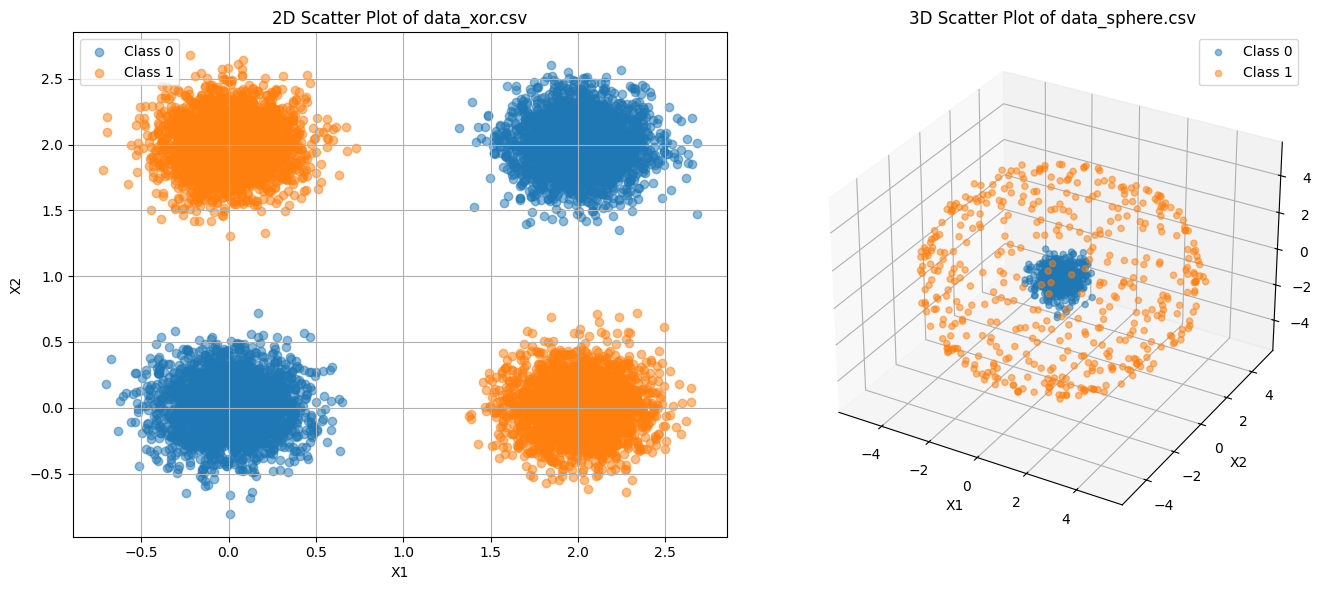

In [306]:
# 2.1 Scatter plots

# Creating the plots side by side
fig = plt.figure(figsize = (14, 6))


# Creating the 2D from data_xor
X_xor = df1[['X1', 'X2']] # features of data_xor
y_xor = df1['Y']
# fig.add_subplot(nrows, ncols, index) -> method for creating subplot within a figure 
ax1 = fig.add_subplot(121)
for label in y_xor.unique():
    subset = X_xor[y_xor == label]
    ax1.scatter(subset['X1'], subset['X2'], label = f'Class {label}', alpha = 0.5)
ax1.set_title("2D Scatter Plot of data_xor.csv")
ax1.set_xlabel("X1")
ax1.set_ylabel("X2")
ax1.legend()
ax1.grid(True)

# Creating the 3D from data_sphere
X_sphere = df2[['X1', 'X2', 'X3']] # features of data_sphere
y_sphere = df2['Y']
ax2 = fig.add_subplot(122, projection = '3d')
for label in y_sphere.unique():
    subset = X_sphere[y_sphere == label]
    ax2.scatter(subset['X1'], subset['X2'], subset['X3'], label=f'Class {label}', alpha=0.5)
ax2.set_title("3D Scatter Plot of data_sphere.csv")
ax2.set_xlabel("X1")
ax2.set_ylabel("X2")
ax2.set_zlabel("X3")
ax2.legend()

plt.tight_layout()
plt.show()

In [307]:
# 2.2 Logistic Regressions

# Splitting data in training sets and validation sets
# test_size = 0.3 in order to allocate 70% of the data for training and 30% for validation 
# For this example I give the random_state = 42 to control the random number generator  
X_xor_train, X_xor_val, y_xor_train, y_xor_val = train_test_split(X_xor, y_xor, test_size=0.3, random_state=42) # For data_xor.csv
X_sphere_train, X_sphere_val, y_sphere_train, y_sphere_val = train_test_split(X_sphere, y_sphere, test_size=0.3, random_state=42) # For data_sphere.csv

# Training logistic regression 
lr_xor = LogisticRegression()
lr_xor.fit(X_xor_train, y_xor_train)

lr_sphere = LogisticRegression()
lr_sphere.fit(X_sphere_train, y_sphere_train)

# To predict and calculate accuracy 
y_xor_pred = lr_xor.predict(X_xor_val)
xor_accuracy = accuracy_score(y_xor_val, y_xor_pred)

y_sphere_pred = lr_sphere.predict(X_sphere_val)
sphere_accuracy = accuracy_score(y_sphere_val, y_sphere_pred)

print(f'Accuracy of logistic regression for data_xor: {xor_accuracy:.4f}')
print(f'Accuracy of logistic regression for data_sphere: {sphere_accuracy:.4f}')

Accuracy of logistic regression for data_xor: 0.4843
Accuracy of logistic regression for data_sphere: 0.5667


# 2.3 Interpret
Logistic regression struggles with non-linearly separable datasets like data_xor and data_sphere. Additionally, it is with low accuracy and the inability to capture complex patterns. Better models are needed for these datasets such as kernel model and neural networks.

In [308]:
# 2.4 Classify data_xor
# Support Vector Machine (SVM) as the Radial Basis Function (RBF) kernel, is used 
svm_model = SVC(kernel = 'rbf', gamma = 'scale', random_state = 42)
svm_model.fit(X_train, y_train)

X_train, X_val, y_train, y_val = train_test_split(X_xor, y_xor, test_size=0.3, random_state=42)

# Predicting on validation set
y_pred = svm_model.predict(X_val)

# Evaluating accuracy 
accuracy = accuracy_score(y_val, y_pred)

print('Accuracy of SVM model on data_xor with RBF kernel is', accuracy)

Accuracy of SVM model on data_xor with RBF kernel is 0.37366666666666665


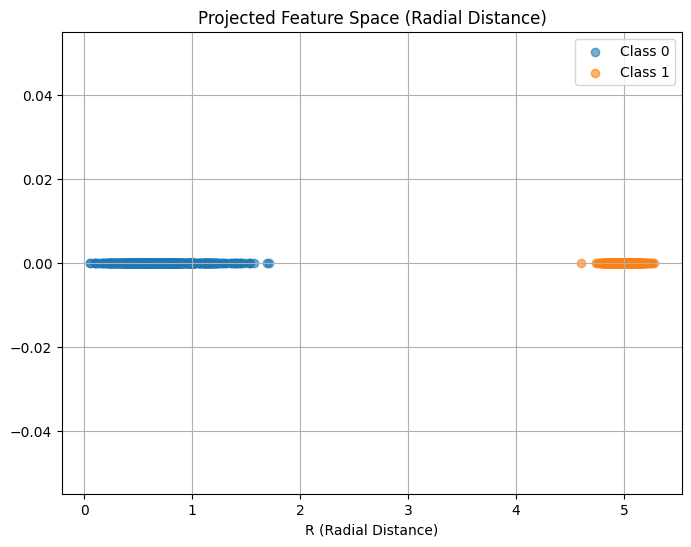

Accuracy on training data after projection used 1.0


In [309]:
# 2.5 Classify sphere
# In order to acheive 100% accuracy we can project the features of data_sphere in a higher-dimensional space where the data becomes linearly seperable 
# A common way is by using radial distance from the origin and use it as a feature

# Defining the projection function 
def project_features(X):
    # Computing radial distance
    R = np.sqrt((X ** 2).sum(axis=1))
    return pd.DataFrame({'R': R})

# Projecting the features
X_projected = project_features(X_sphere)

# Scatter plot in the projected space
plt.figure(figsize=(8, 6))
for label in y_sphere.unique():
    subset = X_projected[y_sphere == label]
    plt.scatter(subset['R'], np.zeros_like(subset['R']), label=f'Class {label}', alpha=0.6)
plt.title("Projected Feature Space (Radial Distance)")
plt.xlabel("R (Radial Distance)")
plt.legend()
plt.grid(True)
plt.show()

# Spliting the data
X_train, X_val, y_train, y_val = train_test_split(X_projected, y_sphere, test_size=0.3, random_state=42)

# Training a logistic regression model on the projected data
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predicting on training set and calculating accuracy
y_train_pred = lr_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print('Accuracy on training data after projection used', train_accuracy) # Output the accuracy 

# 2.6 Explanation of what was done
In subtask 4, The supporting vector machine (SVM) with Radial Basis Function (RBF) kernel creats a none-linear decision boundary in the original space by projecting data in a higher-dimensional space. 
In subtask 5, The radial distance projection (RDP) makes the 3D spherical data simpler in a 1D space then we acheived linear seperability. 

# 2.7 Kernel trick and kernel svm
The primary goal of an SVM is finding a hyperplane that best separates different classes of data points. However, in many real world scenarios, the data is not linearly separable in the original feature space. Therefore, kernel trick comes to help by mapping the original feature space implicitly in a higher dimensional space where the data might be more easily separable.

In [310]:
# 2.8 KernelSVM

# Spliting the data
X_train, X_val, y_train, y_val = train_test_split(X_sphere, y_sphere, test_size=0.3, random_state=42)

# Train an SVM with an RBF kernel
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predicting on the validation set
y_pred = svm_model.predict(X_val)

# Evaluating accuracy
accuracy = accuracy_score(y_val, y_pred)

print('Accuracy of SVM on data_sphere with RBF kernel is: ', accuracy)

Accuracy of SVM on data_sphere with RBF kernel is:  1.0


External Sources: 

1. https://scikit-learn.org/
3. https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
4. https://scikit-learn.org/dev/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html
5. https://scikit-learn.org/1.5/auto_examples/model_selection/plot_learning_curve.html
6. https://medium.com
7. https://chatgpt.com
8. https://www.geeksforgeeks.org/matplotlib-pyplot-scatter-in-python/
9. https://www.analyticsvidhya.com/
10. https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
11. https://medium.com